# Tokenization

In [1]:
from datasets import load_dataset

emotions = load_dataset('emotion')

c:\Users\lived\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

emotions_encoded = emotions.map(tokenize_function, batched=True)

c:\Users\lived\miniconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
emotions_encoded.set_format(type='pandas')
emotions_encoded['train'][:5]

,text,label,input_ids,attention_mask
0,i didnt feel humiliated,0,"[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,i can go from feeling so hopeless to so damned...,0,"[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,im grabbing a minute to post i feel greedy wrong,3,"[101, 10047, 9775, 1037, 3371, 2000, 2695, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
3,i am ever feeling nostalgic about the fireplac...,2,"[101, 1045, 2572, 2412, 3110, 16839, 9080, 128...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,i am feeling grouchy,3,"[101, 1045, 2572, 3110, 24665, 7140, 11714, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."


# Train classification using hidden states

In [4]:
from transformers import AutoModel
import torch

model_ckpt = 'distilbert-base-uncased'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoModel.from_pretrained(model_ckpt).to(device)

print('Model is loaded on:', model.device)


Model is loaded on: cuda:0


In [5]:
texts = [
    'I am happy',
    'I am frustrated',
    'I am sad',
]
tokens = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
tokens = { k:v.to(device) for k,v in tokens.items() }
print('Input shape:', tokens['input_ids'].shape)

with torch.no_grad():
    outputs = model(**tokens)
    print('Output shape:', outputs.last_hidden_state.shape)
    last_hidden_state = outputs.last_hidden_state[:,0]
    print('CLS Tokens:', last_hidden_state.shape)

Input shape: torch.Size([3, 5])
Output shape: torch.Size([3, 5, 768])
CLS Tokens: torch.Size([3, 768])


In [6]:
def extract_hidden_states(batch_tokens):
    inputs = { k:v.to(device) for k,v in batch_tokens.items() if k in tokenizer.model_input_names }
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state[:,0]
    return {'hidden_state': last_hidden_state.cpu().numpy() }

In [7]:
print(emotions_encoded['train'].column_names)
print(tokenizer.model_input_names)

['text', 'label', 'input_ids', 'attention_mask']
['input_ids', 'attention_mask']


In [8]:
emotions_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=16)
emotions_hidden['train'].column_names

Map: 100%|██████████| 2000/2000 [00:09<00:00, 212.02 examples/s]


['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [9]:
import numpy as np
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(16000, 768) (16000,)
(2000, 768) (2000,)


In [10]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=3000)
logreg.fit(X_train, y_train)

logreg.score(X_valid, y_valid)

0.634

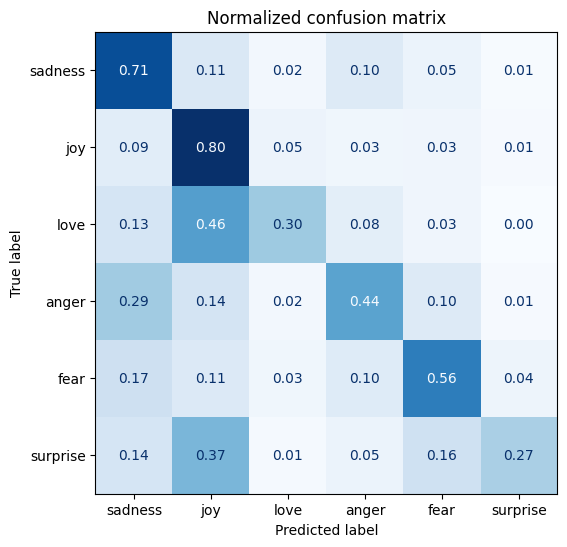

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = emotions['train'].features['label'].names

def plot_confusion_matrix(y_preds, y_true, labels):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_preds, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized confusion matrix')
    plt.show()

y_preds = logreg.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

As we can see there are a lot of misclassifications.

# Fine-tune

In [12]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from sklearn.metrics import f1_score, accuracy_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}

In [14]:
from transformers import Trainer, TrainingArguments

batch_size=64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level='error')

In [18]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer
)

trainer.train()

KeyboardInterrupt: 